<a href="https://colab.research.google.com/github/johnitodo/Cardio-GoodFitness/blob/main/plantspecie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt
import seaborn as sns                                                                 # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the image
img = np.load('/content/drive/MyDrive/Plant_Specie/images.npy')
label = pd.read_csv('/content/drive/MyDrive/Plant_Specie/Labels.csv')

In [ ]:
#checking data samples
label.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [ ]:
#checking distribution of the various categorical labels

label.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

Here we see that data categories is not balanced across each individual category.

In [ ]:
#checking the unique plant species
np.unique(label)


array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

We have 12 unique plant species in this dataset

**Image Specifications**

In [ ]:
#Checking our image dimentions
print(img.shape)
print(f'The label dataframe dimention is {label.shape}')

(4750, 128, 128, 3)
The label dataframe dimention is (4750, 1)


From the above we can see that we have 4750 different images of size 128/128 and they are coloured images which is depicted by the 3 colour channels.



##**Plotting the Images**

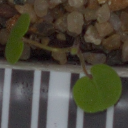

In [ ]:
#Visualising the image with openCV
cv2_imshow(img[10])

OpenCV gives us our image in BGR which does not give the true idea of what the image looks like which ideally should show as RGB like matplotlib. It is therefore important to convert the image into the right colour scheme(format) to get an optimal result.



In [ ]:
# Converting the Image to RGB using cvtColor from OpenCV
for i in range(len(img)):
  img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

**Exploratory Data Analysis of Cleaned Data**

In [ ]:
#Checking the number of unique species
label['Label'].nunique()

12

In [ ]:
#Checking the all the categories and their distribution
label['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

It is observed that the classes are not equally of nearly evenly discriminated.

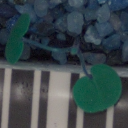

In [ ]:
#Sanity Check
cv2_imshow(img[10])

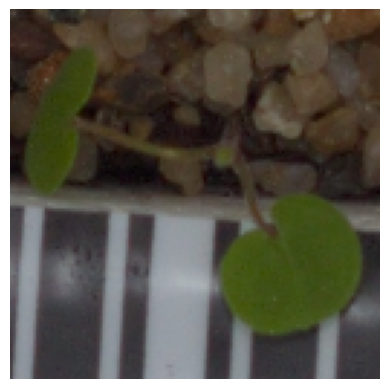

In [ ]:
#visualising in matplotlip
plt.imshow(img[10])
plt.axis('off');

In [ ]:
#Visualising a image samples
def plot_images(img, label):
    categories = np.unique(label)
    keys = dict(label['Label'])
    num_images = 12  # Number of images to display
    num_rows = 3
    num_cols = 4

    # Create the figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
    fig.tight_layout()


    for i in range(num_images):
        if i >= len(label):
            break

        random_index = np.random.randint(0, len(label))
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.imshow(img[random_index, :])
        ax.set_title(keys[random_index])


    plt.show()

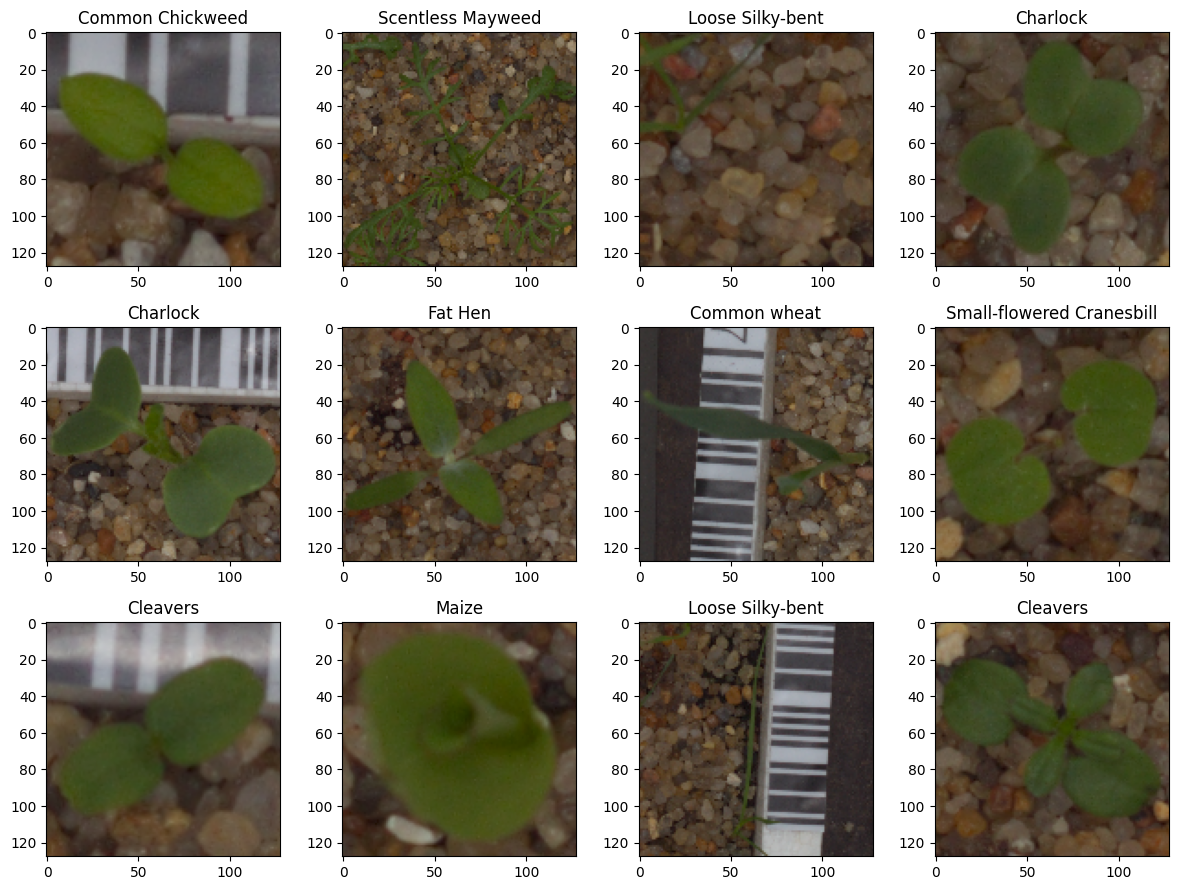

In [ ]:
plot_images(img,label)

###**Visualise The Data Imbalance**

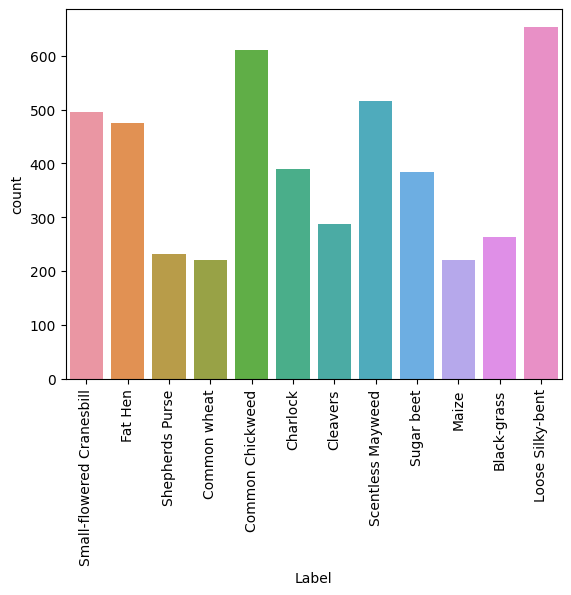

In [ ]:
sns.countplot(data = label, x = 'Label')
plt.xticks(rotation = 90)
plt.show()

##**Image Resizing**

For computational speed, we will be resizing our images
from the large size it is originally in to a more optimised size to aid our model building. We will resize to 128pix to 128

In [ ]:
#Resizing our images
img_resized = [] #empty list of resized images
height = 64
width = 64
dimensions = (width, height)
for i in range(len(img)): #looping through all the image
  img_resized.append(cv2.resize(img[i], dimensions, interpolation = cv2.INTER_LINEAR)) #resizing the images

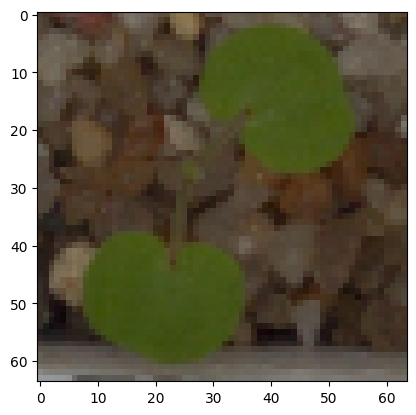

In [ ]:
#visualising resized image
plt.imshow(img_resized[4]);

###**Blurring the Image Background**

By blurring the image, you are denoising the image to enable the deep learning algorithm focus on the image being processed.

In [ ]:
#Applying Gaussian Blur
img_gblur = []
for i in range(len(img)):
  img_gblur.append(cv2.GaussianBlur(img[i], ksize =(3,3),sigmaX = 0))

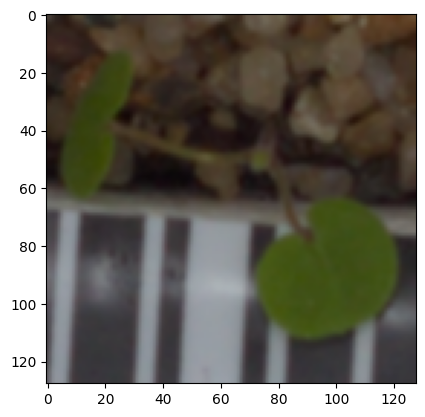

In [ ]:
plt.imshow(img_gblur[10]);

###**Splitting The Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp,X_test,y_temp,y_test = train_test_split(np.array(img_resized),label, test_size=0.1, random_state = 42, stratify = label)
X_train, X_val,y_train, y_val = train_test_split(X_temp, y_temp, test_size =0.1, random_state=42, stratify=y_temp)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)




(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


###**Encoding The Target Labels**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_enc = enc.fit_transform(y_train)
y_val_enc = enc.transform(y_val)
y_test_enc = enc.transform(y_test)

###**Data Normalization**

Our normalisation method will be to scale the data to its original scale which is 255

In [ ]:
#Normalizing the image pixels
X_train_norm = X_train.astype('float32')/255.0
X_val_norm = X_val.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

###**Clearing backend**

In [ ]:
#Clearing the backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

We are setting multiple seed because we want our model to be reproduced

###**The Model Architecture**

In [ ]:
#Initialising a sequential model
model_1 = Sequential()

#Adding first conv with 128 filters
model_1.add(Conv2D(128, (3,3), input_shape = (64,64,3), activation = 'relu'))

# Adding our pooling layer
model_1.add(MaxPooling2D(2,2))

#Adding second conv with 64 filters
model_1.add(Conv2D(64, (3,3), activation = 'relu'))

# Adding our pooling layer
model_1.add(MaxPooling2D(2,2))

#Flattening the output of the conv layer as a precursor to your dense network
model_1.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and Dropout 0.3
model_1.add(Dense(100, activation ='relu'))
model_1.add(Dropout(0.2))

#output layer
model_1.add(Dense(12,activation = 'softmax'))

#instantiating the optimizers
opt = Adam()

#Compiling the model
model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

#Generating the model summary
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 100)               1

In [ ]:
#Defining our early stopping and model checkpoint

model_file1 ='/content/drive/MyDrive/Plant_Specie'

e_stoping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min',verbose = 2)
chkpt = ModelCheckpoint(model_file1, verbose = 2, save_best_only = True)

####**Fitting the model on the train data**

In [ ]:
history = model_1.fit(
    X_train_norm, y_train_enc,
    epochs = 50,
    validation_data =(X_val_norm,y_val_enc),
    batch_size=32,
    verbose=2,
    callbacks = [e_stoping, chkpt]
)

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.01945, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 14s - loss: 2.3523 - accuracy: 0.1775 - val_loss: 2.0194 - val_accuracy: 0.3294 - 14s/epoch - 118ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.01945 to 1.57819, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 4s - loss: 1.8033 - accuracy: 0.3767 - val_loss: 1.5782 - val_accuracy: 0.4930 - 4s/epoch - 30ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.57819 to 1.32968, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 1.5029 - accuracy: 0.4671 - val_loss: 1.3297 - val_accuracy: 0.5491 - 2s/epoch - 19ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.32968 to 1.21151, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 1.3580 - accuracy: 0.5152 - val_loss: 1.2115 - val_accuracy: 0.5958 - 2s/epoch - 17ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.21151 to 1.11772, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 1.2555 - accuracy: 0.5633 - val_loss: 1.1177 - val_accuracy: 0.6098 - 2s/epoch - 17ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.11772 to 1.11341, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 1.1963 - accuracy: 0.5838 - val_loss: 1.1134 - val_accuracy: 0.6215 - 2s/epoch - 18ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.11341 to 1.04963, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 3s - loss: 1.0921 - accuracy: 0.6163 - val_loss: 1.0496 - val_accuracy: 0.6379 - 3s/epoch - 22ms/step
Epoch 8/50

Epoch 8: val_loss improved from 1.04963 to 1.00981, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 1.0437 - accuracy: 0.6327 - val_loss: 1.0098 - val_accuracy: 0.6846 - 2s/epoch - 18ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.00981 to 0.98365, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 0.9962 - accuracy: 0.6517 - val_loss: 0.9836 - val_accuracy: 0.6636 - 2s/epoch - 17ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 0.98365
121/121 - 1s - loss: 0.9855 - accuracy: 0.6545 - val_loss: 0.9871 - val_accuracy: 0.6893 - 1s/epoch - 9ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 0.98365
121/121 - 1s - loss: 0.9511 - accuracy: 0.6686 - val_loss: 1.0038 - val_accuracy: 0.6636 - 1s/epoch - 9ms/step
Epoch 12/50

Epoch 12: val_loss improved from 0.98365 to 0.97375, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 0.9094 - accuracy: 0.6766 - val_loss: 0.9737 - val_accuracy: 0.6822 - 2s/epoch - 20ms/step
Epoch 13/50

Epoch 13: val_loss improved from 0.97375 to 0.90253, saving model to /content/drive/MyDrive/Plant_Specie


121/121 - 2s - loss: 0.8547 - accuracy: 0.7057 - val_loss: 0.9025 - val_accuracy: 0.7266 - 2s/epoch - 20ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 0.90253
121/121 - 1s - loss: 0.8187 - accuracy: 0.7128 - val_loss: 0.9039 - val_accuracy: 0.7033 - 1s/epoch - 11ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 0.90253
121/121 - 1s - loss: 0.8197 - accuracy: 0.7083 - val_loss: 0.9359 - val_accuracy: 0.7033 - 1s/epoch - 10ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 0.90253
121/121 - 1s - loss: 0.7734 - accuracy: 0.7250 - val_loss: 0.9873 - val_accuracy: 0.6729 - 1s/epoch - 9ms/step
Epoch 16: early stopping


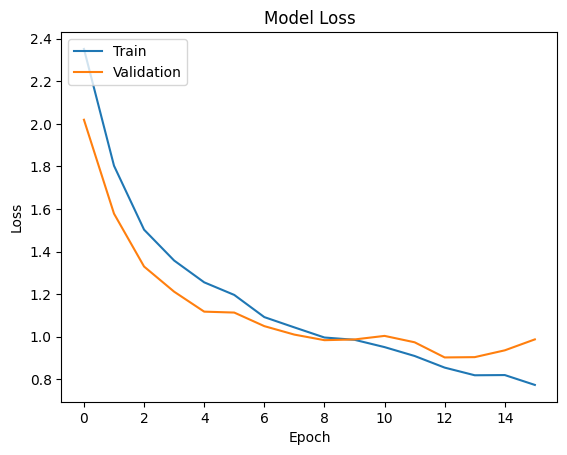

In [ ]:
#Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

### **Observation**
At the onset, our training loss was higher than the validation loss.

This model overfitted.

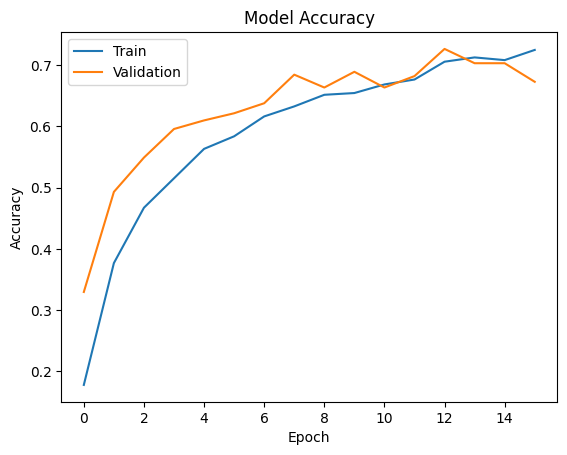

In [ ]:
#Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

In [ ]:
print(X_train_norm.shape)  # Should match the number of samples (3847 in this case)
print(y_train_enc.shape)   # Should also match the number of samples (3847 in this case)
print(X_val_norm.shape)    # Should match the number of validation samples
print(y_val_enc.shape)     # Should also match the number of validation samples


(3847, 64, 64, 3)
(3847, 12)
(428, 64, 64, 3)
(428, 12)


###**Evaluating the model**

In [ ]:
acc = model_1.evaluate(X_test_norm, y_test_enc, verbose = 2)

15/15 - 0s - loss: 0.9877 - accuracy: 0.6905 - 157ms/epoch - 10ms/step


###**Generating The Prediction using test data**

In [ ]:
#Here we would get the output as probabilities for each category
y_pred = model_1.predict(X_test_norm)

15/15 [==============================] - 0s 3ms/step


### **Plotting the confusion matrix**

In [ ]:
import seaborn as sns

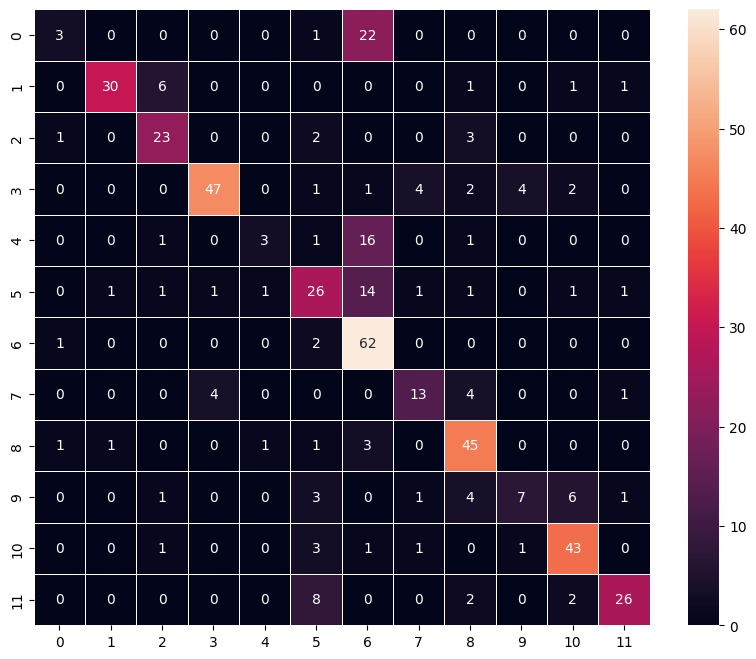

In [ ]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_enc, axis = 1)

#plotting the confusion matrics () function which ia also predefined tensorflow  module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
  confusion_matrix,
  annot = True,
  linewidths = .4,
  fmt = 'd',
  square = True,
  ax=ax
)
plt.show()

##### **Observation**

The model successfully classified most of the classes.

there was high misclassifications on classes 0,4

###### **#NB**
The model leanrned from the training data, but we believe that it can still improve further

 **MODEL 2**

 As an improvement step, we will attempt to augument our data because as previously observed our data categories where significantly imbalanced across the classes. Also, we will try out some batch normalisation.

In [ ]:
#Clearing the backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Usig the Image generator, all image to be rescales by 1/255
train_datagen = ImageDataGenerator( rotation_range=180,
                                   fill_mode='nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,

)

#test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [ ]:
#Initialising a sequential model
model1 = Sequential()

#Adding first conv with 128 filters
model1.add(Conv2D(128, (3,3), input_shape = (64,64,3), activation = 'relu'))

# Adding our pooling layer
model1.add(MaxPooling2D(2,2))

#Adding second conv with 64 filters
model1.add(Conv2D(64, (3,3), activation = 'relu'))

# Adding our pooling layer
model1.add(MaxPooling2D(2,2))

#Flattening the output of the conv layer as a precursor to your dense network
model1.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and Dropout 0.3
model1.add(Dense(100, activation ='relu'))
model1.add(Dropout(0.2))

#output layer
model1.add(Dense(12,activation = 'softmax'))

#instantiating the optimizers
opt = Adam()

#Compiling the model
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

#Generating the model summary
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 100)               1

# **Training the model**

In [ ]:
#Epochs
epochs = 25

#Batch Size
batch_size = 64

history_1 = model1.fit(train_datagen.flow(X_train_norm,y_train_enc,
                                          batch_size=batch_size,
                                          seed = 42,
                                          shuffle=False,),
                                          epochs = epochs,
                                          steps_per_epoch= X_train_norm.shape[0]//batch_size,
                                          validation_data =(X_val_norm, y_val_enc),
                                          verbose=1,
                                          callbacks = [e_stoping, chkpt])

Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 2.3876 - accuracy: 0.1790
Epoch 1: val_loss did not improve from 0.90253
60/60 [==============================] - 7s 84ms/step - loss: 2.3876 - accuracy: 0.1790 - val_loss: 2.2365 - val_accuracy: 0.2850
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 1.9818 - accuracy: 0.3214
Epoch 2: val_loss did not improve from 0.90253
60/60 [==============================] - 6s 108ms/step - loss: 1.9818 - accuracy: 0.3214 - val_loss: 1.7007 - val_accuracy: 0.3972
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 1.7093 - accuracy: 0.3962
Epoch 3: val_loss did not improve from 0.90253
60/60 [==============================] - 5s 80ms/step - loss: 1.7093 - accuracy: 0.3962 - val_loss: 1.5122 - val_accuracy: 0.4720
Epoch 4/25
60/60 [==============================] - ETA: 0s - loss: 1.6243 - accuracy: 0.4441
Epoch 4: val_loss did not improve from 0.90253
60/60 [==============================] - 6s 1

60/60 [==============================] - 8s 129ms/step - loss: 1.0520 - accuracy: 0.6418 - val_loss: 0.8942 - val_accuracy: 0.7477
Epoch 15/25
60/60 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.6537
Epoch 15: val_loss improved from 0.89418 to 0.87417, saving model to /content/drive/MyDrive/Plant_Specie


60/60 [==============================] - 6s 99ms/step - loss: 1.0292 - accuracy: 0.6537 - val_loss: 0.8742 - val_accuracy: 0.7383
Epoch 16/25
59/60 [============================>.] - ETA: 0s - loss: 0.9795 - accuracy: 0.6727
Epoch 16: val_loss did not improve from 0.87417
60/60 [==============================] - 7s 112ms/step - loss: 0.9795 - accuracy: 0.6727 - val_loss: 0.9354 - val_accuracy: 0.7290
Epoch 17/25
60/60 [==============================] - ETA: 0s - loss: 1.0016 - accuracy: 0.6698
Epoch 17: val_loss improved from 0.87417 to 0.85492, saving model to /content/drive/MyDrive/Plant_Specie


60/60 [==============================] - 6s 107ms/step - loss: 1.0016 - accuracy: 0.6698 - val_loss: 0.8549 - val_accuracy: 0.7383
Epoch 18/25
60/60 [==============================] - ETA: 0s - loss: 0.9685 - accuracy: 0.6741
Epoch 18: val_loss improved from 0.85492 to 0.80627, saving model to /content/drive/MyDrive/Plant_Specie


60/60 [==============================] - 7s 120ms/step - loss: 0.9685 - accuracy: 0.6741 - val_loss: 0.8063 - val_accuracy: 0.7640
Epoch 19/25
60/60 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.6778
Epoch 19: val_loss did not improve from 0.80627
60/60 [==============================] - 5s 83ms/step - loss: 0.9562 - accuracy: 0.6778 - val_loss: 0.8531 - val_accuracy: 0.7453
Epoch 20/25
60/60 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6902
Epoch 20: val_loss did not improve from 0.80627
60/60 [==============================] - 7s 114ms/step - loss: 0.9240 - accuracy: 0.6902 - val_loss: 0.8512 - val_accuracy: 0.7103
Epoch 21/25
60/60 [==============================] - ETA: 0s - loss: 0.9441 - accuracy: 0.6730
Epoch 21: val_loss improved from 0.80627 to 0.78737, saving model to /content/drive/MyDrive/Plant_Specie


60/60 [==============================] - 7s 110ms/step - loss: 0.9441 - accuracy: 0.6730 - val_loss: 0.7874 - val_accuracy: 0.7780
Epoch 22/25
60/60 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.6931
Epoch 22: val_loss did not improve from 0.78737
60/60 [==============================] - 7s 115ms/step - loss: 0.9049 - accuracy: 0.6931 - val_loss: 0.8166 - val_accuracy: 0.7477
Epoch 23/25
60/60 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.6913
Epoch 23: val_loss did not improve from 0.78737
60/60 [==============================] - 7s 113ms/step - loss: 0.9085 - accuracy: 0.6913 - val_loss: 0.7946 - val_accuracy: 0.7710
Epoch 24/25
60/60 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.6960
Epoch 24: val_loss did not improve from 0.78737
60/60 [==============================] - 5s 81ms/step - loss: 0.8860 - accuracy: 0.6960 - val_loss: 0.7949 - val_accuracy: 0.7407
Epoch 24: early stopping


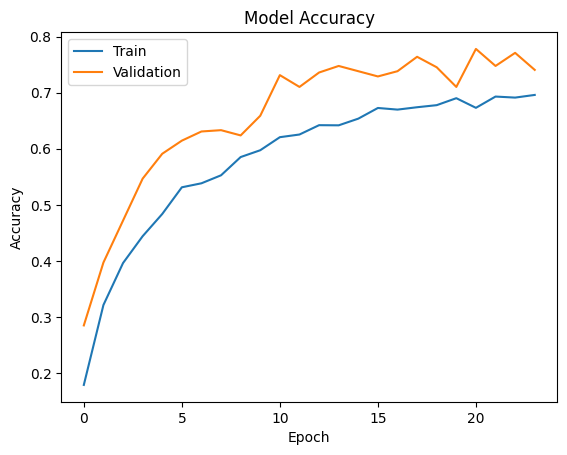

In [ ]:
#Plotting the accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

In [ ]:
acc1 = model1.evaluate(X_test_norm, y_test_enc, verbose = 2)

15/15 - 0s - loss: 0.8022 - accuracy: 0.7726 - 97ms/epoch - 6ms/step


In [ ]:
#Here we would get the output as probabilities for each category
y_pred1 = model1.predict(X_test_norm)

15/15 [==============================] - 0s 4ms/step


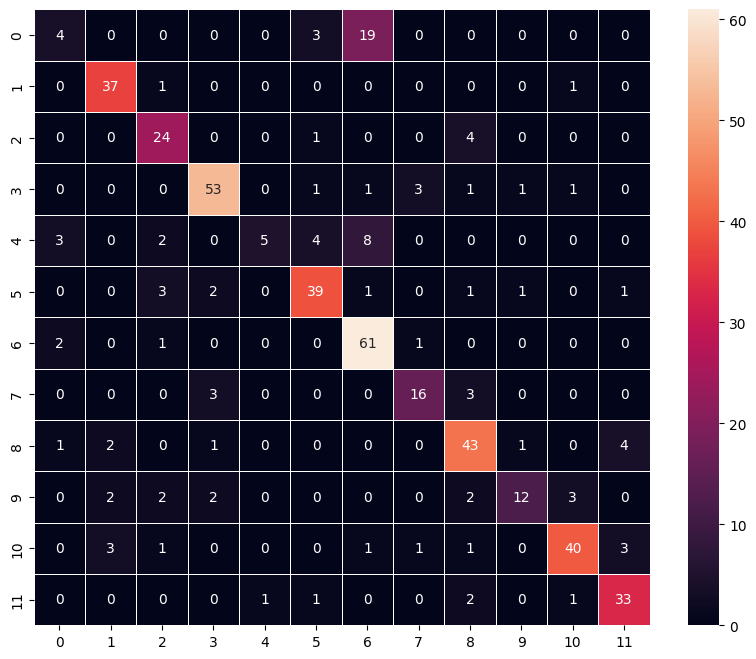

In [ ]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg1 = np.argmax(y_pred1, axis=1)
y_test_arg1 = np.argmax(y_test_enc, axis = 1)

#plotting the confusion matrics () function which ia also predefined tensorflow  module
confusion_matrix = tf.math.confusion_matrix(y_test_arg1, y_pred_arg1)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
  confusion_matrix,
  annot = True,
  linewidths = .4,
  fmt = 'd',
  square = True,
  ax=ax
)
plt.show()

# **Transfer Learning**

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16(weights = 'imagenet', include_top= False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
#Here we are freezing the layers to enable vgg weight that has been generated
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
vg_model = Sequential()

#Adding the vgg convolutional block
vg_model.add(vgg_model)

#Flattening the output of the vGG MODEL
vg_model.add(Flatten())

#Adding a dense output layer
vg_model.add(Dense(128, activation='relu'))
vg_model.add(Dropout(0.2))
vg_model.add(Dense(64, activation='relu'))
vg_model.add(Dense(32, activation='relu'))
vg_model.add(Dense(12, activation='softmax'))
opt=Adam(lr=0.5)



#Compiler
vg_model.compile(optimizer=opt, loss ='categorical_crossentropy', metrics=['accuracy'])

#Generating the summary of the model
vg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 12)               

**Training**

In [ ]:
#Epochs
epochs1 = 50

#Batch size
batch_size1 = 64

vg_hist = vg_model.fit(train_datagen.flow(X_train_norm, y_train_enc,
                                          batch_size=batch_size1,
                                          seed=42,
                                          shuffle=False),
                                          epochs=epochs1,
                                          steps_per_epoch=X_train_norm.shape[0] // batch_size,
                                          validation_data=(X_val_norm, y_val_enc),
                                          verbose=1,
                                          callbacks = [e_stoping, chkpt])

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 2.2085 - accuracy: 0.2294
Epoch 1: val_loss did not improve from 0.78737
60/60 [==============================] - 11s 151ms/step - loss: 2.2085 - accuracy: 0.2294 - val_loss: 1.9574 - val_accuracy: 0.3061
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 1.8112 - accuracy: 0.3611
Epoch 2: val_loss did not improve from 0.78737
60/60 [==============================] - 5s 88ms/step - loss: 1.8112 - accuracy: 0.3611 - val_loss: 1.6817 - val_accuracy: 0.3832
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 1.6376 - accuracy: 0.4092
Epoch 3: val_loss did not improve from 0.78737
60/60 [==============================] - 6s 93ms/step - loss: 1.6376 - accuracy: 0.4092 - val_loss: 1.5668 - val_accuracy: 0.4369
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.4549
Epoch 4: val_loss did not improve from 0.78737
60/60 [==============================] - 5s 

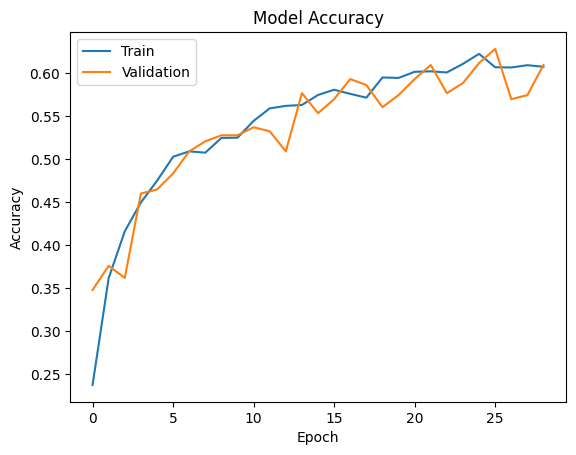

In [ ]:
#Plotting the accuracy
plt.plot(vg_hist.history['accuracy'])
plt.plot(vg_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

In [ ]:
acc2 = vg_model.evaluate(X_test_norm, y_test_enc, verbose = 2)

15/15 - 0s - loss: 1.1779 - accuracy: 0.6021 - 275ms/epoch - 18ms/step


In [ ]:
#Here we would get the output as probabilities for each category
y_pred2 = model1.predict(X_test_norm)

15/15 [==============================] - 0s 4ms/step


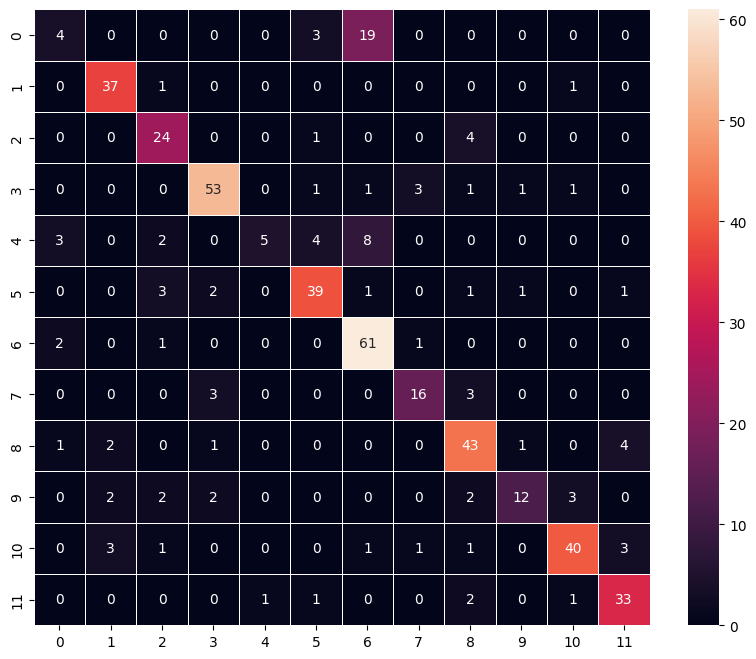

In [ ]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg2 = np.argmax(y_pred2, axis=1)
y_test_arg2 = np.argmax(y_test_enc, axis = 1)

#plotting the confusion matrics () function which ia also predefined tensorflow  module
confusion_matrix1 = tf.math.confusion_matrix(y_test_arg2, y_pred_arg2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
  confusion_matrix1,
  annot = True,
  linewidths = .4,
  fmt = 'd',
  square = True,
  ax=ax
)
plt.show()

### **Observation**
We observed that the last model which was built based on pretrained weights vgg16 did not perform better that the previous model which was built using augumented data. of all the 3 models the model that performed best was the secound model, it had the least loss of 0.8022 and the highest accuracy of 0.7726